In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import product
from loguru import logger

from carbon.estimate import estimate_carbon_footprint
from carbon.llm import estimate_raw

In [2]:
# Structured Outputs with response_format: {type: "json_schema", ...} are supported for the following models:
models = ['gpt-4o-2024-08-06', 'gpt-4o-mini-2024-07-18']

In [15]:
# From Berners-Lee, M. (2022). *The carbon footprint of everything* (2nd ed.). Greystone Books.

data = [
    ("a disposable diaper", "United States", 0.13),
    ("a roll of toilet paper", "United States", 0.73),
    ("a pint of milk", "United States", 0.9),
    ("a paperback book", "United States", 1),
    ("a night in a hotel", "United States", 75),
    ("a week’s food shopping", "United States", 81),    
    ("Manzanas", "Chile", 0.315567090225564),
    ("Peras", "Chile",0.151477857142857),
    ("Platanos", "Chile", 0.199110481203008),
    ("Carne de res", "Chile",15.5),
    ("Leche de almendra", "Chile",0.8),#https://www.foodunfolded.com/es/articulo/leche-de-origen-vegetal-la-huella-ecologica,
    ("Café molido", "Chile",3.27814541353384),
    ("Aguacates", "Chile",0.665384045112782),
    ("Queso cheddar", "Chile",0.74),
    ("Bolsa de Papel", "Chile",0.064),
    ("Teléfono inteligente", "Chile",63),
    ("Laptop", "Chile",422.5),
    ("Camiseta de algodón", "Chile", 15),
    ("Jeans de mezclilla", "Chile",13.5733333333333),
    ("Paneles solares", "Chile",0.0249677556390977),
    ("Andar en Bicicleta", "Chile",0),
    ("Automóvil eléctrico", "Chile",21000),
    ("Botella de agua reutilizable", "Chile",0.1405),
    ("Batería AA Alcalina", "Chile",0.0702062135338346),
    ("Cerveza", "Chile",0.707145556),
    ("Vino tinto", "Chile", 2.020833042),
    ("Chocolate caliente", "Chile", 2.519647737),
    ("Pan integral", "Chile",0.826108796992481),
    ("Yogur griego", "Chile", 2.1089522556391),
    ("Huevo", "Chile", 0.183),
    ("Mantequilla de maní", "Chile", 0.183),
    ("Salmón ahumado", "Chile",5.93363436090226),
    ("Tofu", "Chile",5.93363436090226),
    ("Garbanzos", "Chile", 0.4),
    ("Una noche de hotel", "Chile", 27.6),
    ("Un viaje en transporte público", "Chile", 1.03),
    ("Una lavada de ropa en lavadora", "Chile",3.3),
    ("Una comida en un restaurante", "Chile",8),#https://www.gotenzo.com/resources/insight/the-carbon-neutral-restaurant-a-pipedream-or-an-inevitability/,
    ("Un viaje en avión de 1 hora", "Chile",1.46),#https://www.tandfonline.com/doi/pdf/10.1080/17583004.2017.1412232?needAccess=true,
    ("Un trayecto en taxi de 10 km", "Chile",1),
    ("Una videollamada de Zoom 1 hora", "Chile",0.02),
    ("El uso de aire acondicionado por 8 horas", "Chile",3653),
    ("Un corte de cabello", "Chile",3.1),#https://britishbeautycouncil.com/net-zero-now/,
    ("Un viaje en tren de 10 km", "Chile", 0.37),
    ("Una caminata", "Chile", 0)
]

In [16]:
results = []
for model, (item, country, expected) in product(models, data):
    logger.info(f"Estimating carbon footprint for {item} in {country} using {model} model")
    # using the raw estimate
    start_time = time.time()
    result_raw, cost = estimate_raw(item, country, model=model)
    end_time = time.time()
    results.append({
        "model": model,
        "item": item,
        "country": country,
        "predicted": result_raw.carbon_footprint,
        "expected": expected,
        "time": end_time - start_time,
    })

    logger.info(f"Estimating carbon footprint for {item} in {country} using {model}_carbon model")
    # using our carbon footprint estimate
    start_time = time.time()
    result = estimate_carbon_footprint(item, country, model=model)
    end_time = time.time()
    results.append({
        "model": f"{model}_carbonada",
        "item": item,
        "country": country,
        "predicted": result.carbon_footprint,
        "expected": expected,
        "time": end_time - start_time,
    })

2024-08-24 21:36:02.374 | INFO     | __main__:<module>:3 - Estimating carbon footprint for a disposable diaper in United States using gpt-4o-2024-08-06 model
2024-08-24 21:36:04.491 | INFO     | __main__:<module>:17 - Estimating carbon footprint for a disposable diaper in United States using gpt-4o-2024-08-06_carbon model
2024-08-24 21:36:09.695 | INFO     | __main__:<module>:3 - Estimating carbon footprint for a roll of toilet paper in United States using gpt-4o-2024-08-06 model
2024-08-24 21:36:11.475 | INFO     | __main__:<module>:17 - Estimating carbon footprint for a roll of toilet paper in United States using gpt-4o-2024-08-06_carbon model
2024-08-24 21:36:18.130 | INFO     | __main__:<module>:3 - Estimating carbon footprint for a pint of milk in United States using gpt-4o-2024-08-06 model
2024-08-24 21:36:19.646 | INFO     | __main__:<module>:17 - Estimating carbon footprint for a pint of milk in United States using gpt-4o-2024-08-06_carbon model
2024-08-24 21:36:24.088 | INFO  

In [17]:
df = pd.DataFrame(results)
df.to_csv('../data/processed/medium-eval.csv', index=False)
df.head()

,model,item,country,predicted,expected,time
0,gpt-4o-2024-08-06,a disposable diaper,United States,0.250000,0.13,2.115161
1,gpt-4o-2024-08-06_carbonada,a disposable diaper,United States,0.159003,0.13,5.202908
2,gpt-4o-2024-08-06,a roll of toilet paper,United States,0.500000,0.73,1.779289
3,gpt-4o-2024-08-06_carbonada,a roll of toilet paper,United States,0.608593,0.73,6.654263
4,gpt-4o-2024-08-06,a pint of milk,United States,0.500000,0.90,1.514021


In [18]:
# Calculate MAE for each prediction
df['mae'] = abs(df['predicted'] - df['expected'])
df['mape'] = abs((df['predicted'] - df['expected']) / df['expected']) * 100

# Group by model to calculate the average MAE and time for each model
model_comparison = df.groupby('model').agg(
    average_mae=('mae', 'mean'),
    average_mape=('mape', 'mean'),
    average_time=('time', 'mean')
).reset_index()



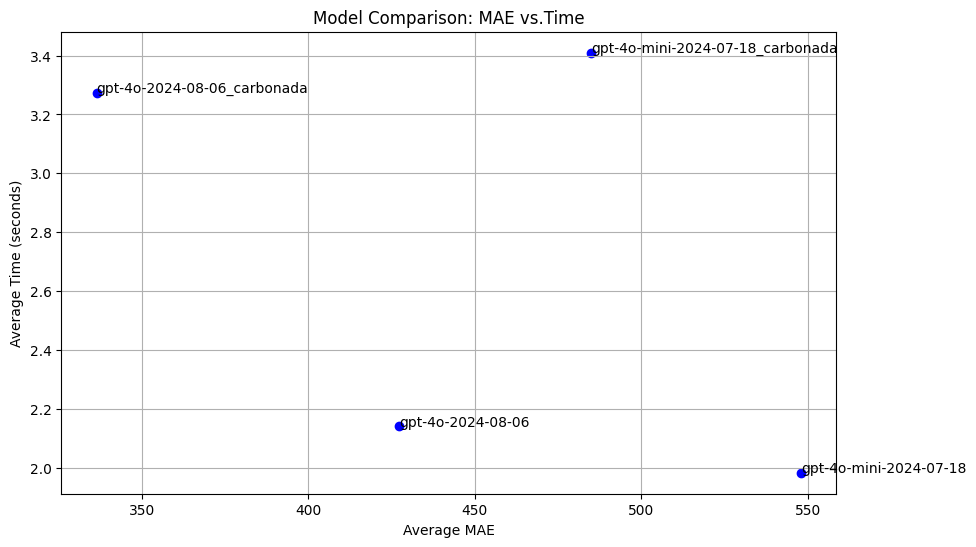

In [19]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.scatter(model_comparison['average_mae'], model_comparison['average_time'], color='blue')

# Annotate points with model names
for i in range(len(model_comparison)):
    plt.text(model_comparison['average_mae'][i], model_comparison['average_time'][i], model_comparison['model'][i])

plt.xlabel('Average MAE')
plt.ylabel('Average Time (seconds)')
plt.title('Model Comparison: MAE vs.Time')
plt.grid(True)
plt.savefig('../reports/figures/model_comparison_mae_medium.png')
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
c:\work\personal\carbon\.venv\Lib\site-packages\matplotlib\transforms.py:354: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


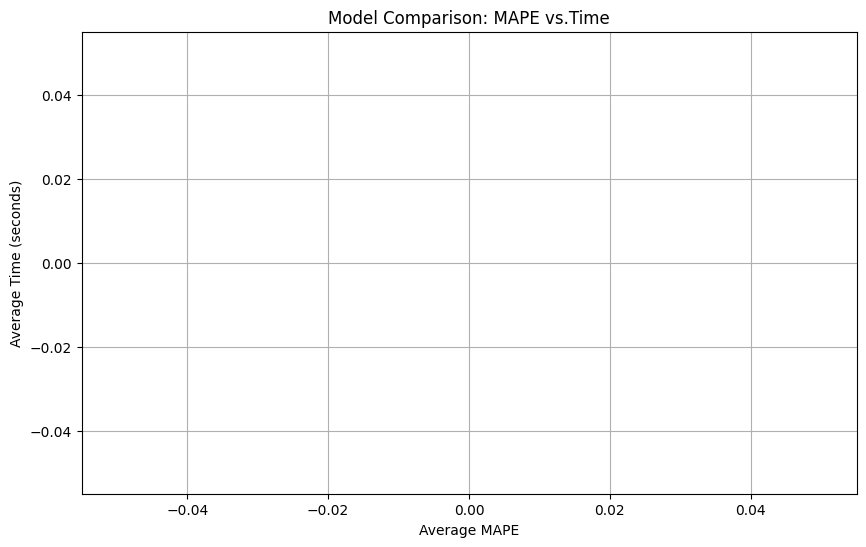

In [20]:
# Plotting the comparison
plt.figure(figsize=(10, 6))
plt.scatter(model_comparison['average_mape'], model_comparison['average_time'], color='blue')

# Annotate points with model names
for i in range(len(model_comparison)):
    plt.text(model_comparison['average_mape'][i], model_comparison['average_time'][i], model_comparison['model'][i])

plt.xlabel('Average MAPE')
plt.ylabel('Average Time (seconds)')
plt.title('Model Comparison: MAPE vs.Time')
plt.grid(True)
plt.savefig('../reports/figures/model_comparison_mape_medium.png')
plt.show()

In [21]:
df_sorted = df.sort_values(by=['item', 'mae'])

# Assign a rank to each model within each item group based on MAE
df_sorted['mae_rank'] = df_sorted.groupby('item')['mae'].rank(method='min')

# Display the ranked DataFrame
df_sorted.head()

,model,item,country,predicted,expected,time,mae,mape,mae_rank
114,gpt-4o-mini-2024-07-18,Aguacates,Chile,1.500000,0.665384,1.608534,0.834616,125.433719,1.0
25,gpt-4o-2024-08-06_carbonada,Aguacates,Chile,2.357676,0.665384,1.868723,1.692292,254.333063,2.0
24,gpt-4o-2024-08-06,Aguacates,Chile,2.500000,0.665384,2.272609,1.834616,275.722865,3.0
115,gpt-4o-mini-2024-07-18_carbonada,Aguacates,Chile,2.947095,0.665384,1.374514,2.281711,342.916329,4.0
130,gpt-4o-mini-2024-07-18,Andar en Bicicleta,Chile,0.100000,0.000000,6.755560,0.100000,inf,1.0


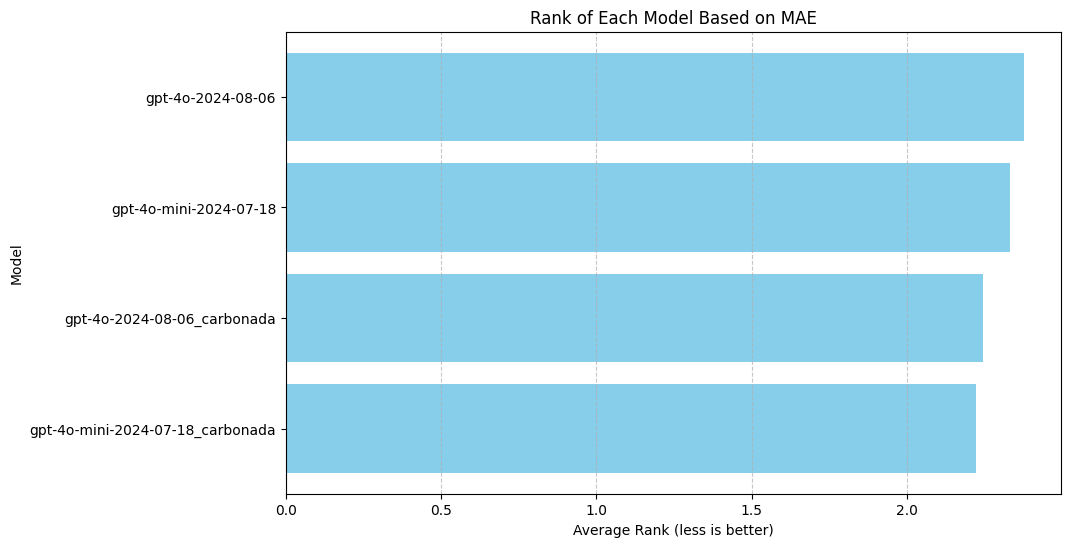

In [22]:
average_rank = df_sorted.groupby('model')['mae_rank'].mean().reset_index()

# Sort models by average rank for better visualization
average_rank = average_rank.sort_values(by='mae_rank')

# Plotting the average ranks
plt.figure(figsize=(10, 6))
plt.barh(average_rank['model'], average_rank['mae_rank'], color='skyblue')
plt.xlabel('Average Rank (less is better)')
plt.ylabel('Model')
plt.title('Rank of Each Model Based on MAE')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('../reports/figures/model_ranking_mae_medium.png')
plt.show()